# Neural Network Tutorial

In [370]:
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

## Prepare the Data

We will use the same South African heart disease data we have been using to now.

There is nothing new here so we will quickly run through this.

In [371]:
file_name = 'SAheart.data'
data = pd.read_csv(file_name, sep=',', index_col=0)

In [372]:
data['famhist_true'] = data['famhist'] == 'Present'
data['famhist_false'] = data['famhist'] == 'Absent'
data = data.drop(['famhist'], axis=1)
data.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_true,famhist_false
row.names,,,,,,,,,,,
1,160,12.00,5.73,23.11,49,25.30,97.20,52,1,True,False
2,144,0.01,4.41,28.61,55,28.87,2.06,63,1,False,True
3,118,0.08,3.48,32.28,52,29.14,3.81,46,0,True,False
4,170,7.50,6.41,38.03,51,31.99,24.26,58,1,True,False
5,134,13.60,3.50,27.78,60,25.99,57.34,49,1,True,False


In [373]:
def get_splits(data):
    np.random.seed(42)
    random.seed(42)
    train, test = model_selection.train_test_split(data)
    x_train = train.loc[:, train.columns != 'chd']
    y_train = train['chd']
    x_test = test.loc[:, test.columns != 'chd']
    y_test = test['chd']
    return x_train, y_train, x_test, y_test

Here we will manually **normalize** the data. We can very conveniently use `sklearn.preprocessing.normalize()` - reference http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html. This is critical. If we don't we may find the neural network won't learn anything useful.

In [374]:
x_train, y_train, x_test, y_test = get_splits(data)
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

# Create a Baseline NN Model

We will create a simple neural network to try and beat our best results with logistic regression and decision trees.

We will use a single hidden layer to learn useful features for our task, and then a final layer to perform classification.

![nn](https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-diagram.jpg)

The clode below uses `keras`, a very simple neural network package. You can study the code here to see what it is doing.

We will use the next cell to control our hyperparameters.

In [375]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

The following cell builds the model to these specifications.

In [376]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=10,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

Neural networks are very sensitive to the statistics in the data. In fact, this dataset is **imbalanced**: we have 160 cases of heart disease and 302 healthy controls. We therefore need to tell the network how to weight the labels so that it doesn't just try and pick "healthy" every time and cheat its way to 65% accuracy.

In [377]:
class_weight = {
    0: 1.,
    1: 160 / 302
}

Now we train the model and see our results.

Epoch 1/20
346/346 [==============================] - 1s 4ms/step - loss: 0.4660 - acc: 0.6214
Epoch 2/20
346/346 [==============================] - 0s 103us/step - loss: 0.4346 - acc: 0.6561
Epoch 3/20
346/346 [==============================] - 0s 98us/step - loss: 0.4335 - acc: 0.6561
Epoch 4/20
346/346 [==============================] - 0s 117us/step - loss: 0.4289 - acc: 0.6561
Epoch 5/20
346/346 [==============================] - 0s 95us/step - loss: 0.4334 - acc: 0.6561
Epoch 6/20
346/346 [==============================] - 0s 94us/step - loss: 0.4156 - acc: 0.6561
Epoch 7/20
346/346 [==============================] - 0s 110us/step - loss: 0.4113 - acc: 0.6561
Epoch 8/20
346/346 [==============================] - 0s 95us/step - loss: 0.4110 - acc: 0.6561
Epoch 9/20
346/346 [==============================] - 0s 130us/step - loss: 0.4032 - acc: 0.6561
Epoch 10/20
346/346 [==============================] - 0s 102us/step - loss: 0.3982 - acc: 0.6561
Epoch 11/20
346/346 [==============

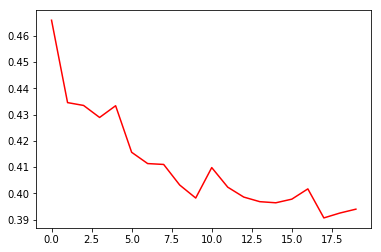

In [378]:
# train the parameters
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

# evaluate accuracy
train_acc = model.evaluate(x, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

## Non-Determinacy

The initial parameters of the network will be randomly determined. We will start on a random part of the loss surface each time. This will lead to a different result.

This is actually a research probelm at the moment. So what can we do if we want a fair competition? We will train our network 20 times and take the average.

In [379]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size, 
                class_weight=class_weight, 
                verbose=False)
            train_accs.append(model.evaluate(x, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

In [380]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████| 20/20 [00:07<00:00,  3.26it/s]

Avgerage Training Accuracy: 0.6979768797324571
Avgerage Testing Accuracy: 0.7137931028316762


That is still giving some variance but if is much more reliable. The more times we average over the more reliable that result will be. It is certainly much better than taking a single run as an indicator of how good a model is.

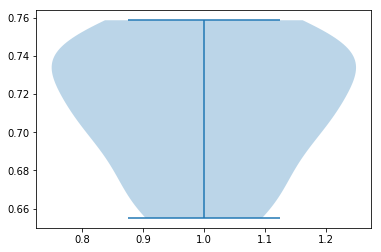

In [381]:
plt.violinplot(test_accs)
plt.show()

In [382]:
print('Min: %s' % np.min(test_accs))
print('Max: %s' % np.max(test_accs))

Min: 0.6551724117377709
Max: 0.758620691710505


## Beat the Baseline

Beat the average testing accuracy of 74.2%.

You can control network and learning hyperparameters in the following cell.

In [366]:
hidden_units = 3    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 50          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

The following cell will build the model according to your hyperparameters above. If you like you can add and remove layers.

In [367]:
def build_model(hidden_units, activation, learning_rate):
    model = models.Sequential()
    model.add(layers.Dense(input_dim=10,
                           units=hidden_units, 
                           activation=activation))
    model.add(layers.Dense(input_dim=hidden_units,
                           units=1,
                           activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  # Adam is a kind of gradient descent
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

model = build_model(hidden_units, activation, learning_rate)

Use the next cell to look at how your learning is proceeding to see how you hyperparameters are going.

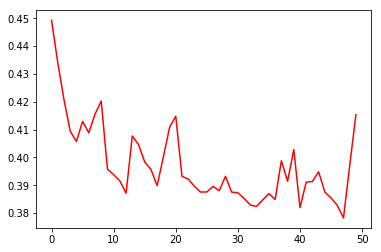

In [368]:
history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, 
    class_weight=class_weight, verbose=False)
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

Use the following cell to get your average test set accuracy.

In [369]:
_, __ = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████| 20/20 [00:14<00:00,  1.49it/s]

Avgerage Training Accuracy: 0.707947977860539
Avgerage Testing Accuracy: 0.7224137917674821
